In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import time
from sklearn.preprocessing import MinMaxScaler



import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vus.utils.slidingWindows import find_length
from vus.utils.metrics import metricor

from vus.models.distance import Fourier
from vus.models.feature import Window
from vus.models.cnn import cnn
from vus.models.AE_mlp2 import AE_MLP2
from vus.models.lstm import lstm
from vus.models.ocsvm import OCSVM
from vus.models.poly import POLY
from vus.models.pca import PCA
from vus.models.norma import NORMA
from vus.models.matrix_profile import MatrixProfile
from vus.models.lof import LOF
from vus.models.iforest import IForest

from vus.analysis.score_computation import generate_data,compute_score
from vus.analysis.robustness_eval import compute_anomaly_acc_pairwise,normalize_dict_exp,group_dict,box_plot,generate_curve



/opt/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


# Training anomaly detection model

In this example, we train 9 different model on 4 possible datasets (we chooser by default the MBA(805) dataset, which is a dataset with easy to detect anomalies). For this statistical analysis, we choose in purpose the 10,000 first points. 

In [2]:
import os
all_files = [] 
for file in os.listdir('../../data'):
    all_files.append('../../data/{}'.format(file))

## Training all methods and computing the anomaly score

In [3]:
import json
import pickle

methods = [
    'NormA',
    'IForest',
    'AE',
    'OCSVM',
    'MatrixProfile',
    'LOF',
    'LSTM',
    'CNN',
]

max_length = 10000
filepath = '../../data/MBA_ECG805_data.out'

pos_first_anom,slidingWindow,data,X_data,data_train,data_test,X_train,X_test,label = generate_data(filepath,0,max_length)
methods_scores =  compute_score(methods,slidingWindow,data,X_data,data_train,data_test,X_train,X_test)

## Visualization of the anomaly scores

In green we plot the "accurate methods". We consider accurate a method that visually seems to identify correctly (entire subsequences, and with significantly higher values on the score) the anoamlies. On the contrary, we plot in red the "inaccurate" methods (i.e. "less accurate" than the first four methods).

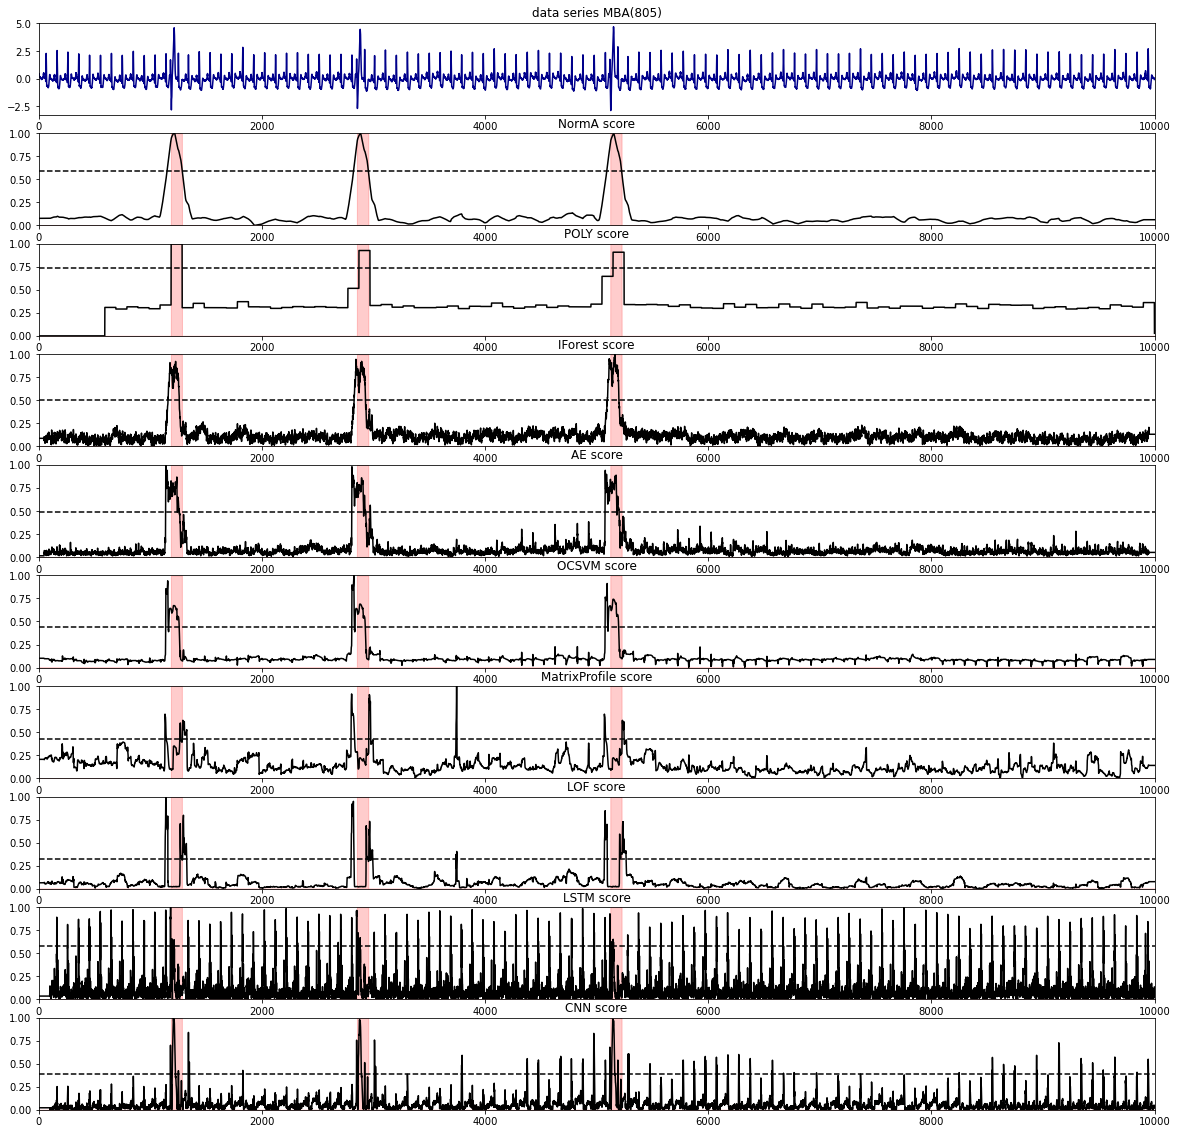

In [4]:
plt.figure(figsize=(20,20))
plt.subplot(10,1,1)
plt.plot(data,color='darkblue')
plt.xlim(0,len(data))
plt.title('data series MBA(805)')
for i,method in enumerate(methods):
    plt.subplot(10,1,2+i)
    if method in ['NormA','IForest','AE','OCSVM']:
        plt.plot(methods_scores[method],color='darkgreen')
    else:
        plt.plot(methods_scores[method],color='darkred')
    plt.fill_between(list(range(len(methods_scores[method]))),[0]*len(methods_scores[method]),label,alpha=0.2,color='red')
    plt.title("{} score".format(method))
    plt.xlim(0,len(methods_scores[method]))
    plt.ylim(0,1)
    plt.hlines(np.mean(methods_scores[method])+3*np.std(methods_scores[method]), 0,len(label),linestyle='--')




# Statistical analysis

## Separability

We then compare the accuracy values (for 13 different accuracy measures) when applying them to accurate and inaccurate anomaly detection methods. This choice is made visually from the previous plot. We also randomly inject lag and noise into the corresponding anomaly score and compute the detection accuracy 60 times.

For each accuracy measure, we thus obtain two sets of accuracy values $X_a$ and $X_b$ for both accurate and inaccurate methods, respectively. Finally, we use the Z-test to evaluate the differences between $X_a$ and $X_b$ distributions:

$$
z\text{-}test = \frac{\mu(X_a) - \mu(X_i)}{\sqrt{\sigma(X_a)^2 + \sigma(X_i)^2}}
$$

In [5]:
methods_acc_random_pair_norma_CNN = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"NormA","CNN")
methods_acc_random_pair_norma_LSTM = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"NormA","LSTM")
methods_acc_random_pair_IF_CNN = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"IForest","CNN")
methods_acc_random_pair_IF_LSTM = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"IForest","LSTM")

methods_acc_random_pair_AE_CNN = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"AE","CNN")
methods_acc_random_pair_AE_LSTM = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"AE","LSTM")
methods_acc_random_pair_OCSVM_CNN = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"OCSVM","CNN")
methods_acc_random_pair_OCSVM_LSTM = compute_anomaly_acc_pairwise(methods_scores,label,slidingWindow,"OCSVM","LSTM")

In [6]:
def normalize_dict_exp_pair(methods_acc_lag,methods_keys):
    key_metrics = [
        'VUS_ROC','VUS_PR',
        'R_AUC_ROC','R_AUC_PR','AUC_ROC',
        'AUC_PR','Rprecision','Rrecall','RF',
        'Precision','Recall','F','Precision@k'][::-1]
    
    norm_methods_acc_lag = {}
    for key in methods_keys:
        norm_methods_acc_lag[key] = {}
        for key_metric in key_metrics:
            ts = list(methods_acc_lag[key][key_metric])
            new_ts = list(np.array(ts))
            norm_methods_acc_lag[key][key_metric] = new_ts
    return norm_methods_acc_lag

group_methods_acc_random_pair_norma_CNN = normalize_dict_exp_pair(methods_acc_random_pair_norma_CNN,methods_keys=["NormA","CNN"])
group_methods_acc_random_pair_norma_LSTM = normalize_dict_exp_pair(methods_acc_random_pair_norma_LSTM,methods_keys=["NormA","LSTM"])

group_methods_acc_random_pair_IF_CNN = normalize_dict_exp_pair(methods_acc_random_pair_IF_CNN,methods_keys=["IForest","CNN"])
group_methods_acc_random_pair_IF_LSTM = normalize_dict_exp_pair(methods_acc_random_pair_IF_LSTM,methods_keys=["IForest","LSTM"])

group_methods_acc_random_pair_AE_CNN = normalize_dict_exp_pair(methods_acc_random_pair_AE_CNN,methods_keys=["AE","CNN"])
group_methods_acc_random_pair_AE_LSTM = normalize_dict_exp_pair(methods_acc_random_pair_AE_LSTM,methods_keys=["AE","LSTM"])

group_methods_acc_random_pair_OCSVM_CNN = normalize_dict_exp_pair(methods_acc_random_pair_OCSVM_CNN,methods_keys=["OCSVM","CNN"])
group_methods_acc_random_pair_OCSVM_LSTM = normalize_dict_exp_pair(methods_acc_random_pair_OCSVM_LSTM,methods_keys=["OCSVM","LSTM"])


# Separability analysis applied on MBA(805)

We apply the separability analysis on the MBA(805) dataset with 8 pairs of accurate versus inaccurate methods

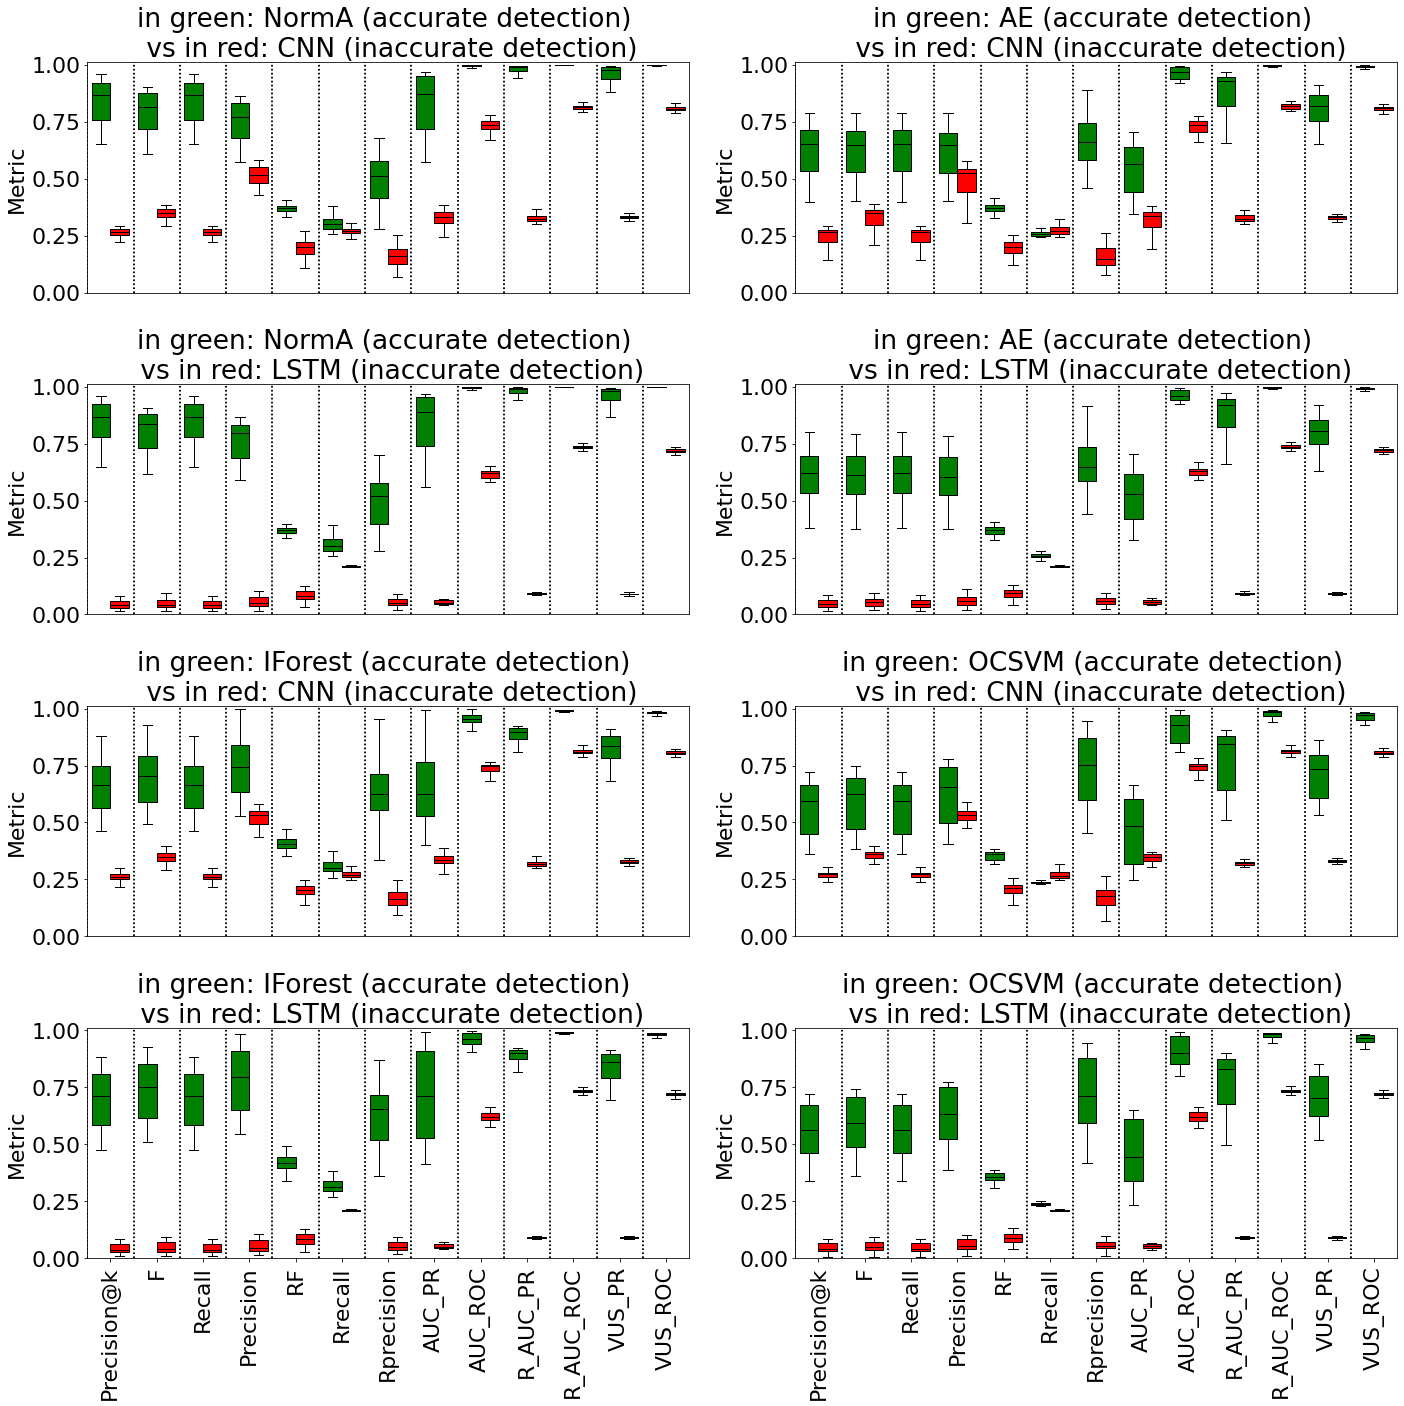

In [7]:


def generate_box_plot_pair(group_methods_acc_random_pair_norma_CNN,names,show_labels=False):

    colors = ['green','red']
    for i,key in enumerate(group_methods_acc_random_pair_norma_CNN.keys()):
        #plt.subplot(1,2,1+i)    
        if i == 1:
            pos = 0.40
        else:
            pos = -0.40
        labels, data = [*zip(*group_methods_acc_random_pair_norma_CNN[key].items())]  # 'transpose' items to parallel key, value lists
        position = [val*2+pos for val in list(range(1,len(labels)+1))]
        bp = plt.boxplot(data,showfliers=False,positions=position,patch_artist=True, widths=0.8)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black')
        for patch in bp['boxes']:
            patch.set(facecolor=colors[i])
        for vl in np.array(list(range(1, len(labels) + 1)))*2:
            plt.axvline(vl - 1,0,1,linestyle='dotted',color='black')
    plt.xlim(1,(np.array(list(range(1, len(labels) + 1)))*2)[-1]+1)
    plt.ylim(0,1.01)
    plt.ylabel('Metric')
    if show_labels:
        plt.xticks(np.array(list(range(1, len(labels) + 1)))*2, labels, rotation=90)
    else:
        plt.xticks([])
    plt.title('in green: {} (accurate detection) \n vs in red: {} (inaccurate detection)'.format(names[0],names[1]))


plt.figure(figsize=(20,20))

plt.rcParams.update({'font.size': 22})
plt.subplot(4,2,1)
generate_box_plot_pair(group_methods_acc_random_pair_norma_CNN,names=['NormA','CNN'])
plt.subplot(4,2,3)
generate_box_plot_pair(group_methods_acc_random_pair_norma_LSTM,names=['NormA','LSTM'])
plt.subplot(4,2,5)
generate_box_plot_pair(group_methods_acc_random_pair_IF_CNN,names=['IForest','CNN'])
plt.subplot(4,2,7)
generate_box_plot_pair(group_methods_acc_random_pair_IF_LSTM,names=['IForest','LSTM'],show_labels=True)



plt.subplot(4,2,2)
generate_box_plot_pair(group_methods_acc_random_pair_AE_CNN,names=['AE','CNN'])
plt.subplot(4,2,4)
generate_box_plot_pair(group_methods_acc_random_pair_AE_LSTM,names=['AE','LSTM'])
plt.subplot(4,2,6)
generate_box_plot_pair(group_methods_acc_random_pair_OCSVM_CNN,names=['OCSVM','CNN'])
plt.subplot(4,2,8)
generate_box_plot_pair(group_methods_acc_random_pair_OCSVM_LSTM,names=['OCSVM','LSTM'],show_labels=True)


plt.tight_layout()

plt.savefig('results_figures/separability_exp.pdf',format='pdf')

## z-test computation

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

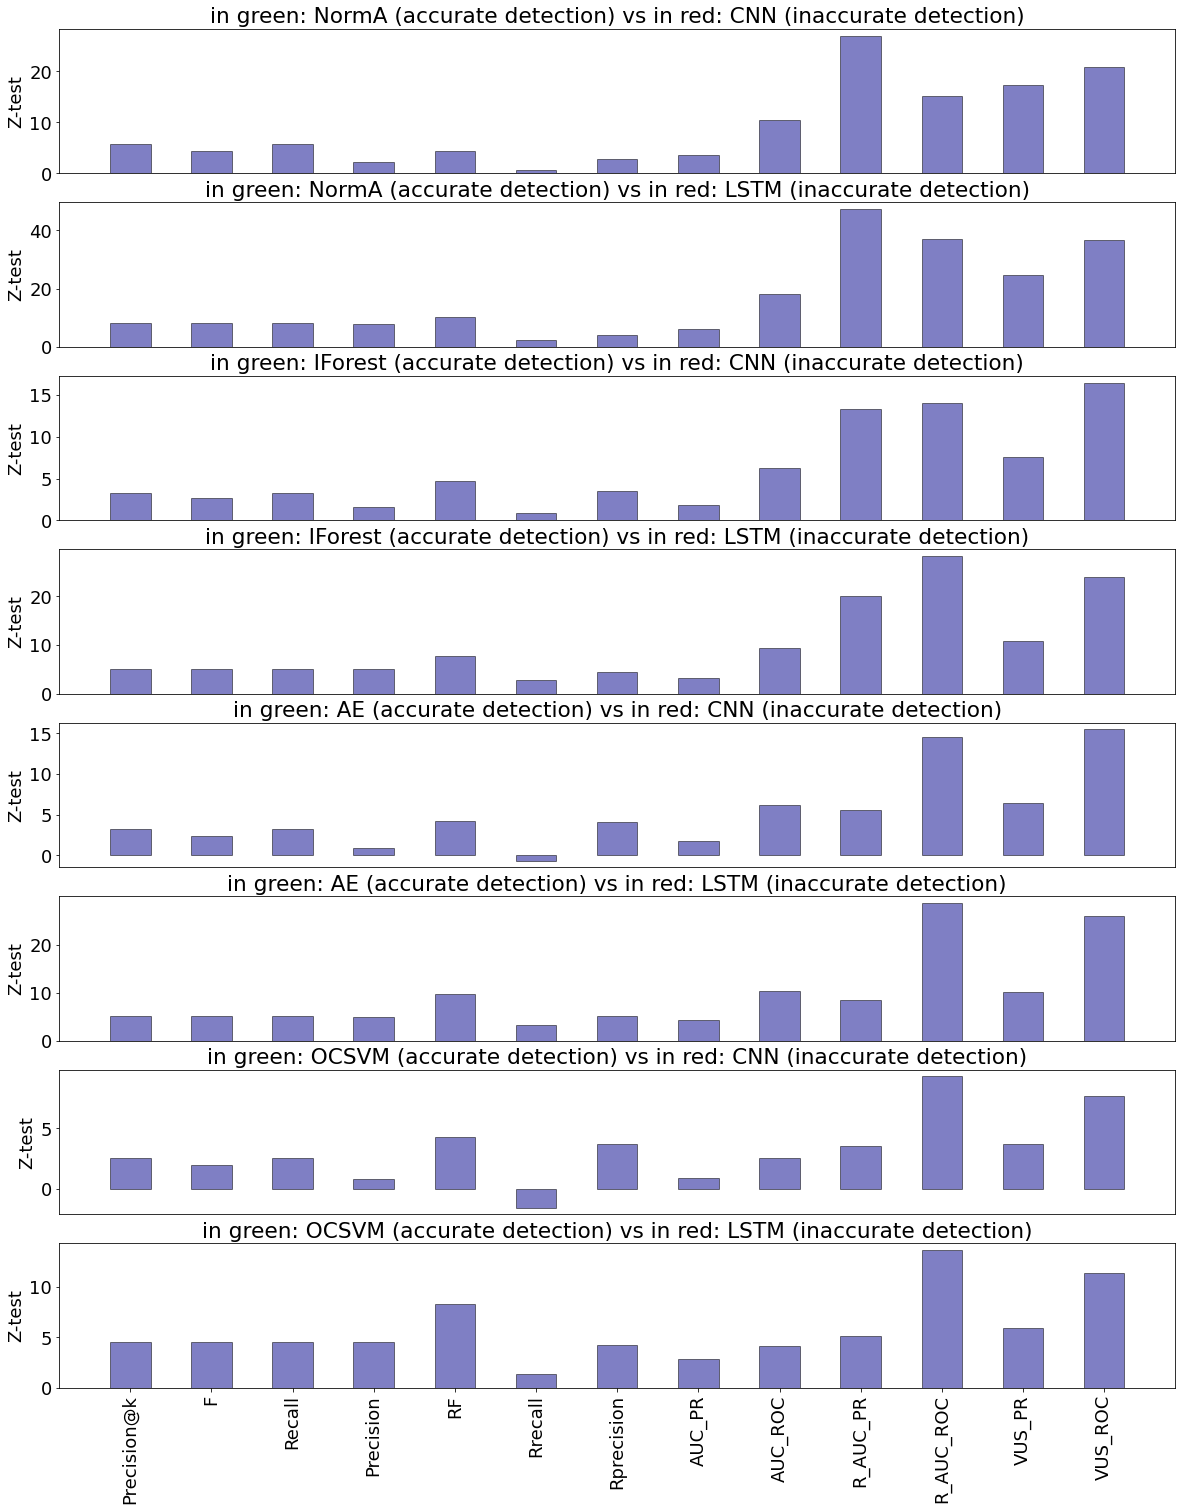

In [17]:
def compute_z_test(group_methods_acc_random_pair_norma_CNN,method_name):
    Z_tests = {}
    for key in group_methods_acc_random_pair_norma_CNN[method_name[0]].keys():
        method_1_mean = np.mean(group_methods_acc_random_pair_norma_CNN[method_name[0]][key])
        method_1_std = np.std(group_methods_acc_random_pair_norma_CNN[method_name[0]][key])

        method_2_mean = np.mean(group_methods_acc_random_pair_norma_CNN[method_name[1]][key])
        method_2_std = np.std(group_methods_acc_random_pair_norma_CNN[method_name[1]][key])
        Z_tests[key] = (method_1_mean - method_2_mean)/np.sqrt(method_1_std**2 + method_2_std**2)
    return Z_tests

def compute_mean_dict_test(list_dict):
    new_dict = {}
    for key in list_dict[0].keys():
        list_val = []
        for dict_s in list_dict:
            list_val.append(dict_s[key])
        new_dict[key] = np.mean(list_val)
    return new_dict
    
    
    
plt.figure(figsize=(20,25))
plt.subplot(8,1,1)
plt.rcParams.update({'font.size': 18})
names=['NormA','CNN']
z_test_1 = compute_z_test(group_methods_acc_random_pair_norma_CNN,method_name=['NormA','CNN'])
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.bar(z_test_1.keys(), z_test_1.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.xticks([])
plt.ylabel('Z-test')
plt.subplot(8,1,2)

names=['NormA','LSTM']
z_test_2 = compute_z_test(group_methods_acc_random_pair_norma_LSTM,method_name=['NormA','LSTM'])
plt.bar(z_test_2.keys(), z_test_2.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.xticks([])
plt.ylabel('Z-test')
plt.subplot(8,1,3)

names=['IForest','CNN']
z_test_3 = compute_z_test(group_methods_acc_random_pair_IF_CNN,method_name=['IForest','CNN'])
plt.bar(z_test_3.keys(), z_test_3.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.xticks([])
plt.ylabel('Z-test')
plt.subplot(8,1,4)

names=['IForest','LSTM']
z_test_4 = compute_z_test(group_methods_acc_random_pair_IF_LSTM,method_name=['IForest','LSTM'])
plt.bar(z_test_4.keys(), z_test_4.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.xticks([])
plt.ylabel('Z-test')
plt.subplot(8,1,5)

names=['AE','CNN']
z_test_1 = compute_z_test(group_methods_acc_random_pair_AE_CNN,method_name=['AE','CNN'])
plt.bar(z_test_1.keys(), z_test_1.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.xticks([])
plt.ylabel('Z-test')
plt.subplot(8,1,6)

names=['AE','LSTM']
z_test_2 = compute_z_test(group_methods_acc_random_pair_AE_LSTM,method_name=['AE','LSTM'])
plt.bar(z_test_2.keys(), z_test_2.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.xticks([])
plt.ylabel('Z-test')
plt.subplot(8,1,7)

names=['OCSVM','CNN']
z_test_3 = compute_z_test(group_methods_acc_random_pair_OCSVM_CNN,method_name=['OCSVM','CNN'])
plt.bar(z_test_3.keys(), z_test_3.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.xticks([])
plt.ylabel('Z-test')
plt.subplot(8,1,8)

names=['OCSVM','LSTM']
z_test_4 = compute_z_test(group_methods_acc_random_pair_OCSVM_LSTM,method_name=['OCSVM','LSTM'])
plt.bar(z_test_4.keys(), z_test_4.values(), width=0.5, color='darkblue',edgecolor='black',alpha=0.5)
plt.ylabel('Z-test')
plt.title('in green: {} (accurate detection) vs in red: {} (inaccurate detection)'.format(names[0],names[1]))
plt.xticks(rotation=90)

## Averaged z-test for all pairs

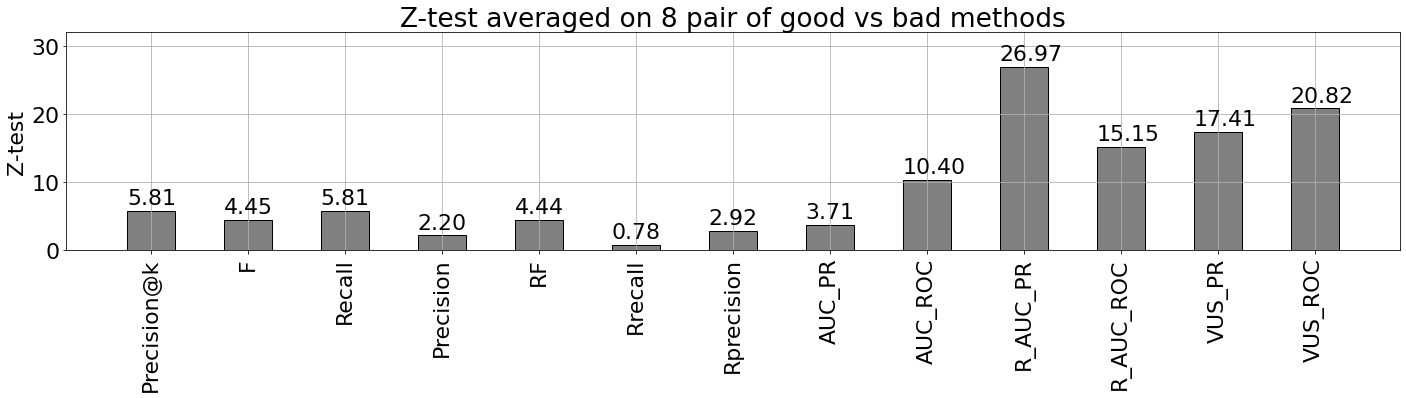

In [9]:
list_z_test = []
method_names = [
    ['NormA','CNN'],
    ['NormA','LSTM'],
    ['IForest','CNN'],
    ['IForest','LSTM'],
    ['AE','CNN'],
    ['AE','LSTM'],
    ['OCSVM','CNN'],
    ['OCSVM','LSTM'],
]
for method_name in method_names:
    list_z_test.append(compute_z_test(group_methods_acc_random_pair_norma_CNN,method_name=['NormA','CNN']))

plt.figure(figsize=(20,6))
plt.grid()
z_test_total = compute_mean_dict_test(list_z_test)
plt.bar(z_test_total.keys(), z_test_total.values(), width=0.5, color='grey',edgecolor='black',alpha=1)
plt.title('Z-test averaged on 8 pair of good vs bad methods')
plt.ylabel('Z-test')
plt.ylim(0,32)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(z_test_total.values()):
    plt.text(xlocs[i] - 0.25, v + 1, "{:.2f}".format(v))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('results_figures/separability_exp_aggregated.pdf',format='pdf')